In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()

In [4]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60801/status,
Dashboard: http://127.0.0.1:60801/status,Workers: 2
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60802,Workers: 2
Dashboard: http://127.0.0.1:60801/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:60810,Total threads: 2
Dashboard: http://127.0.0.1:60812/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:60805,


In [51]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier, SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)



INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='', movement_var=33.31009971953083, movement_mean=0.0),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Identity(environment_name='')],
                                                    [Uniform(environment_name='', environment2_name=None),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Uniform(environment_name='',...
                       environments=(Environment(environment_name='', place_bin_size=0.5268625668325884, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
             

In [11]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

stationary_decoder = SortedSpikesDecoder(environment=environment,
                    transition_type=Identity(),
                    spike_model_penalty=0.5).fit(linear_distance, spikes)

continuous_decoder = SortedSpikesDecoder(environment=environment,
                    transition_type=RandomWalk(movement_var=movement_var * 120),
                    spike_model_penalty=0.5).fit(linear_distance, spikes)

fragmented_decoder = SortedSpikesDecoder(environment=environment,
                    transition_type= Uniform(),
                    spike_model_penalty=0.5).fit(linear_distance, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...
INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...
INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


In [12]:
from replay_trajectory_classification.misc import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [s]')
    sns.despine()


def plot_discrete_state_transition(discrete_state_transition, state_names=None, cmap='Oranges', ax=None,
                                   convert_to_seconds=False, sampling_frequency=1):
    if ax is None:
        ax = plt.gca()
    n_states = discrete_state_transition.shape[0]
    
    if convert_to_seconds:
        discrete_state_transition = (1 / (1 - discrete_state_transition)) / sampling_frequency
        vmin, vmax, fmt = 0.0, None, '0.03f'
        label = 'Seconds'
    else:
        vmin, vmax, fmt = 0.0, 1.0, '0.03f'
        label = 'Probability'

    sns.heatmap(data=discrete_state_transition,
                vmin=vmin, vmax=vmax, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=state_names, yticklabels=state_names, ax=ax,
                cbar_kws={'label': label})
    ax.set_ylabel('Previous State', fontsize=12)
    ax.set_xlabel('Current State', fontsize=12)
    ax.set_title('Discrete State Transition', fontsize=16)

## Test Data Log Likelihood

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

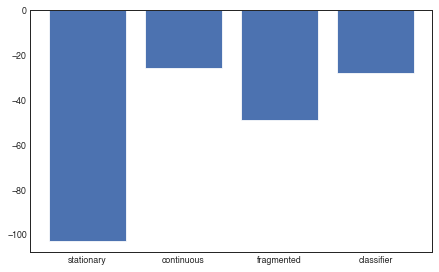

In [41]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

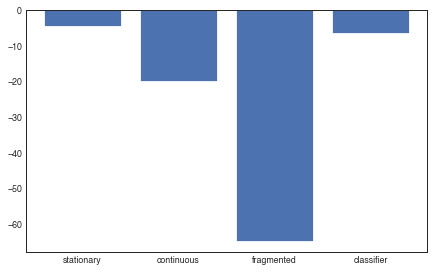

In [42]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_replay

replay_time, test_spikes = make_hover_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

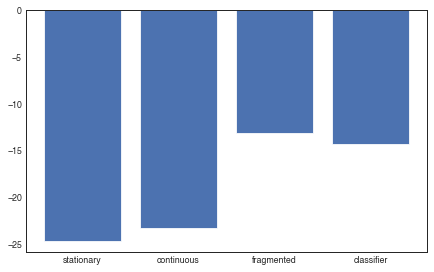

In [43]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

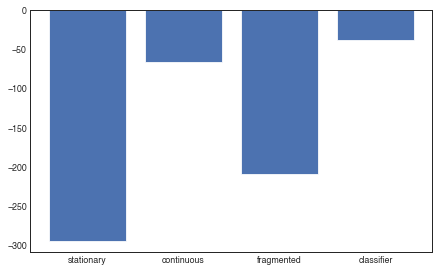

In [45]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay

replay_time, test_spikes = make_hover_continuous_hover_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

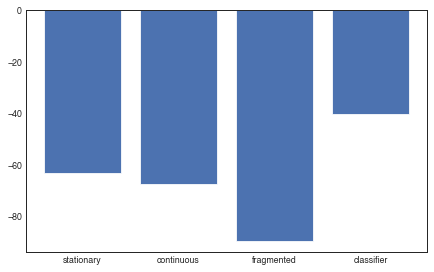

In [46]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

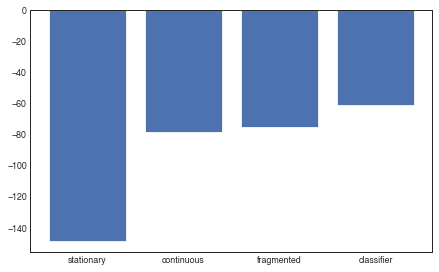

In [47]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...


-28.090729785603394


INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-25.964600096297684


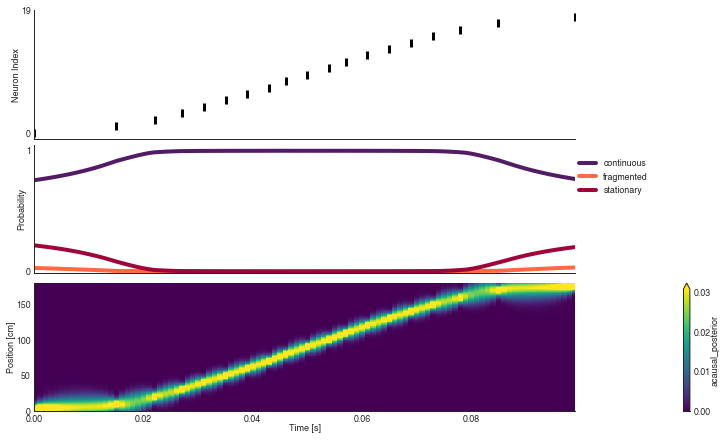

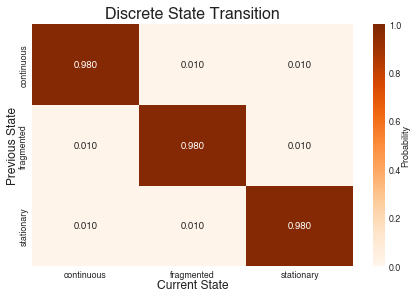

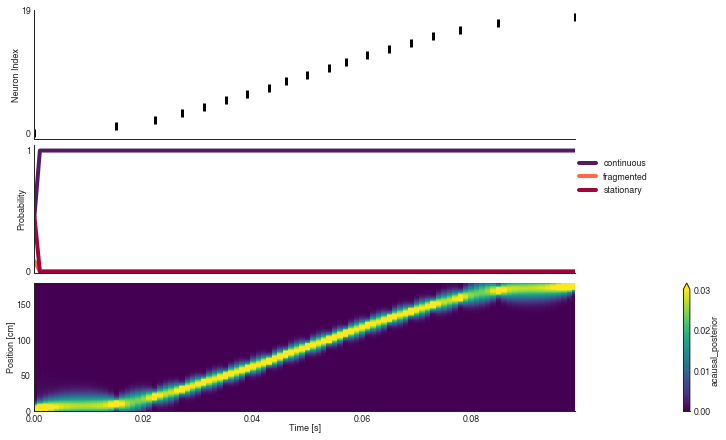

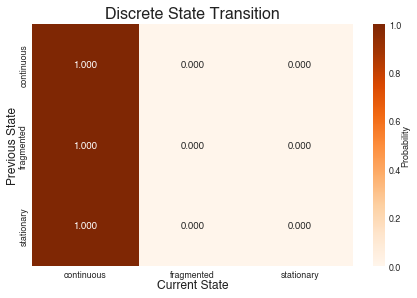

In [52]:
replay_time, test_spikes = make_continuous_replay()


state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier2 = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier2.fit(linear_distance, spikes)

A = np.zeros((3, 3))
A[:, 0] = 1
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-37.790552447011265


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-66.70738803728104


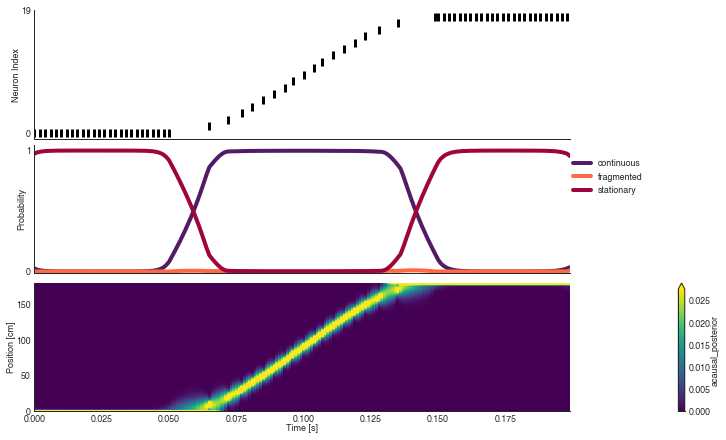

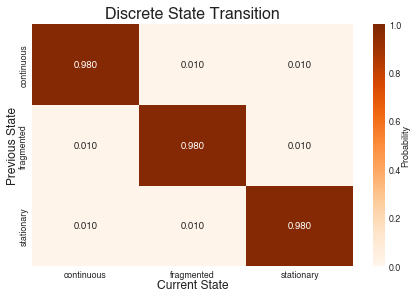

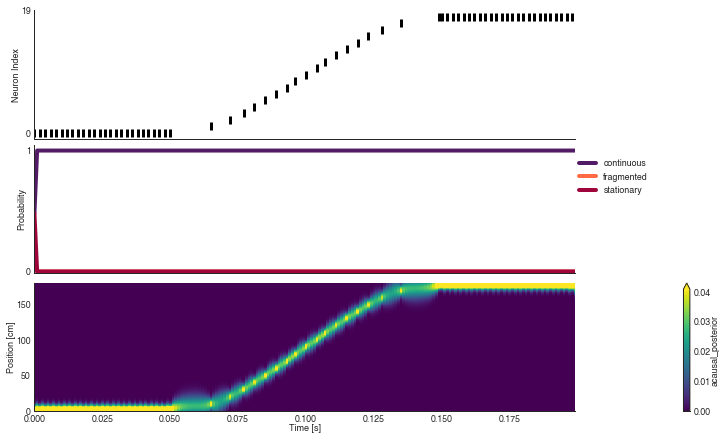

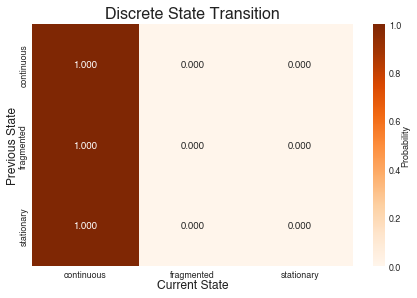

In [53]:
replay_time, test_spikes = make_hover_continuous_hover_replay()


state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


A = np.zeros((3, 3))
A[:, 0] = 1
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-37.790552447011265


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-35.83297878009731


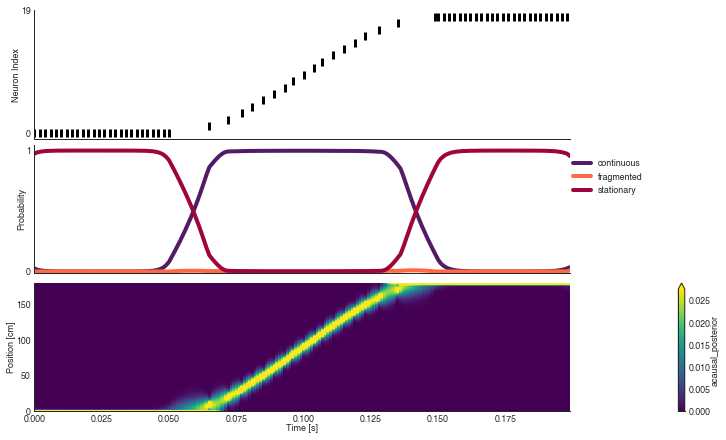

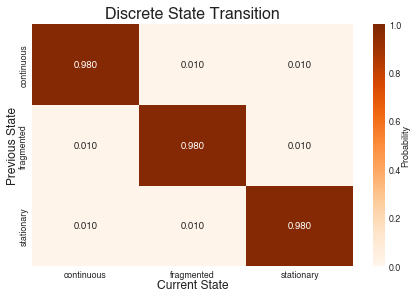

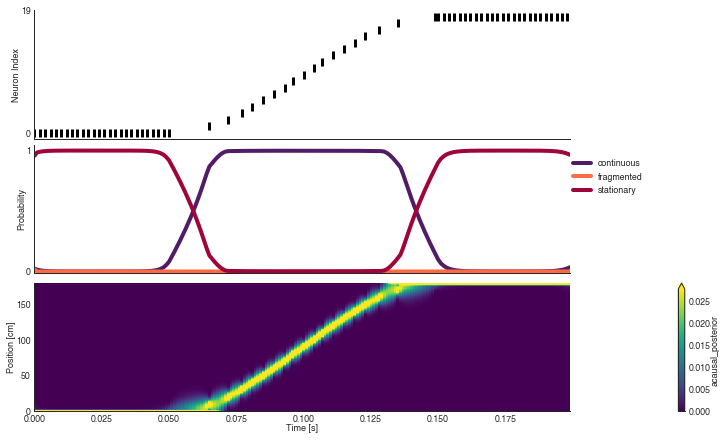

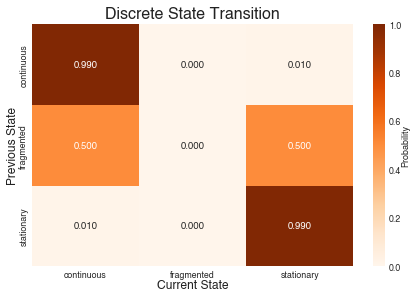

In [69]:
replay_time, test_spikes = make_hover_continuous_hover_replay()


state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


A = np.zeros((3, 3))
A[0, 0] = 1 - (1 / make_continuous_replay()[0].shape[0])
A[0, 2] = 1 / make_continuous_replay()[0].shape[0]
A[2, 2] = 1 - (1 / (make_hover_replay()[0].shape[0] * 2))
A[2, 0] = 1 / (make_hover_replay()[0].shape[0] * 2)
A[1, 1] = 0.0
A[1, ::2] = 0.5
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikeses, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-53.238877294284556


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-50.078644728988344


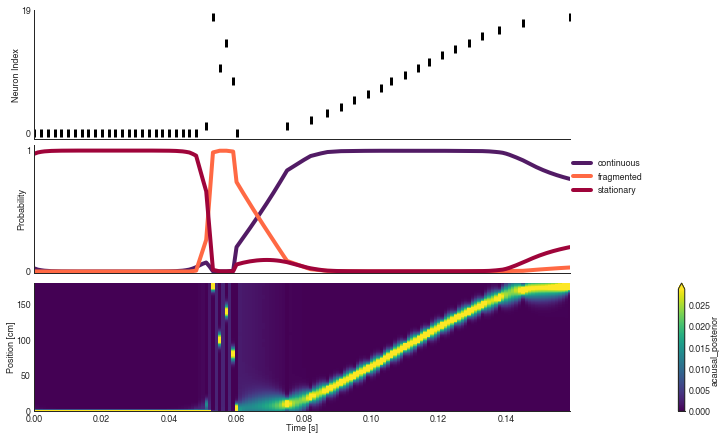

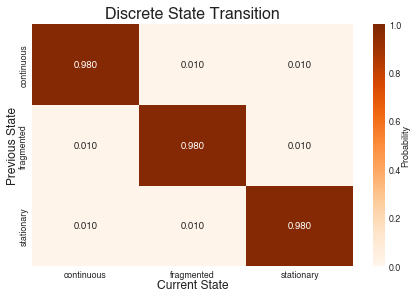

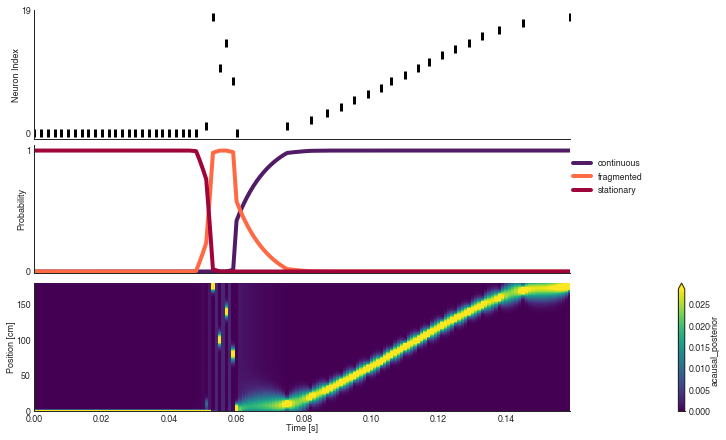

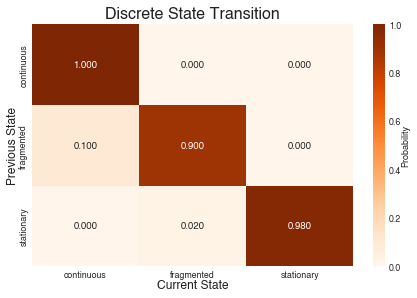

In [80]:
_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)
_, test_spikes2 = make_fragmented_replay()
_, test_spikes3 = make_continuous_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes3))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


A = np.zeros((3, 3))
A[0, 0] = 1


A[1, 1] = 1 - (1 / make_fragmented_replay()[0].shape[0])
A[1, 0] = (1 / make_fragmented_replay()[0].shape[0])

A[2, 2] = 1 - (1 / (make_hover_replay()[0].shape[0]))
A[2, 1] = 1 / (make_hover_replay()[0].shape[0])
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

## Estimating transition matrix

In [243]:
def estimate_discrete_state_transition(results):
    acausal_prob = results.acausal_posterior.sum('position').values
    discrete_state_transition = (acausal_prob[:-1, :, np.newaxis] * acausal_prob[1:, np.newaxis, :]).sum(axis=0) + 1e-32
    discrete_state_transition = np.nan_to_num(
        discrete_state_transition / discrete_state_transition.sum(axis=-1, keepdims=True))
    
    return discrete_state_transition

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-31.471626252670212


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-36.243970408699525


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-40.96161146858593


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-42.85454158672225


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-43.171993665969225


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-43.18922521847506


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-43.17869464500288


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-43.16769749420796


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-43.158305119472246


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-43.15044747501875


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-43.14390149336836


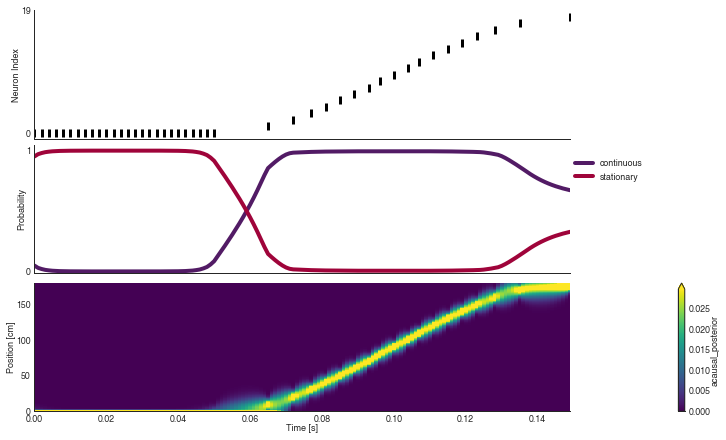

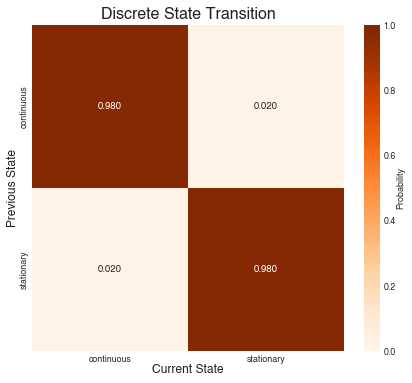

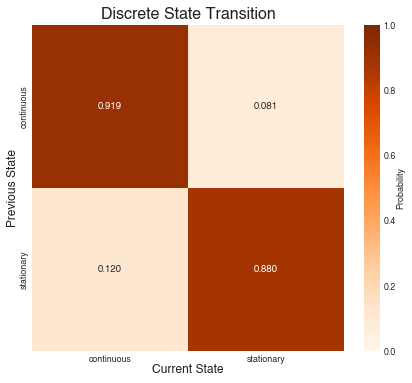

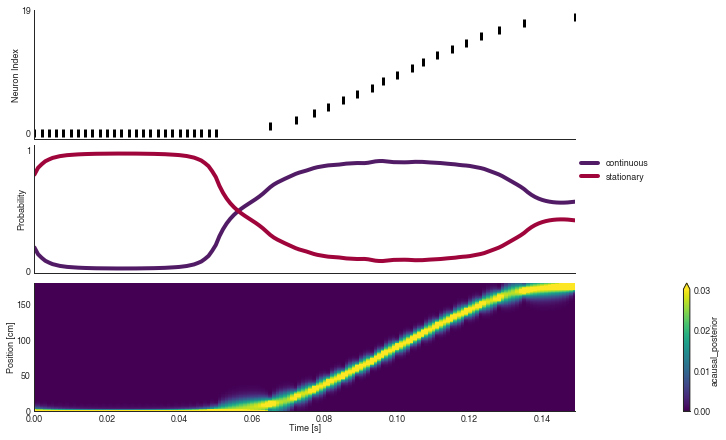

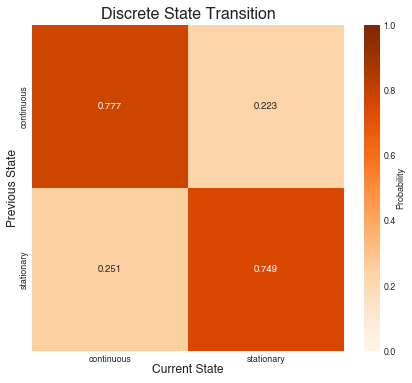

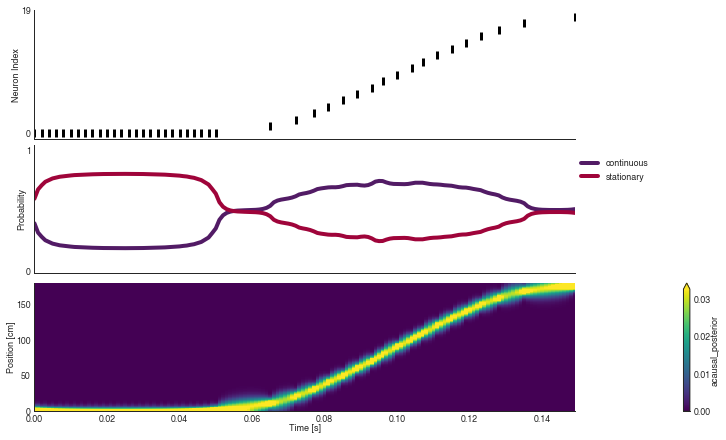

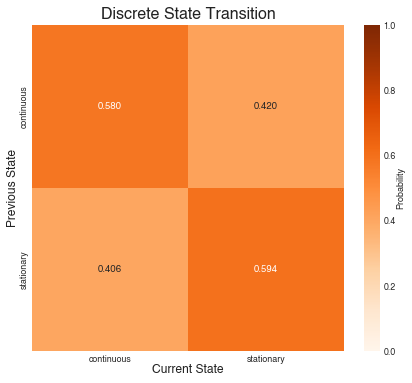

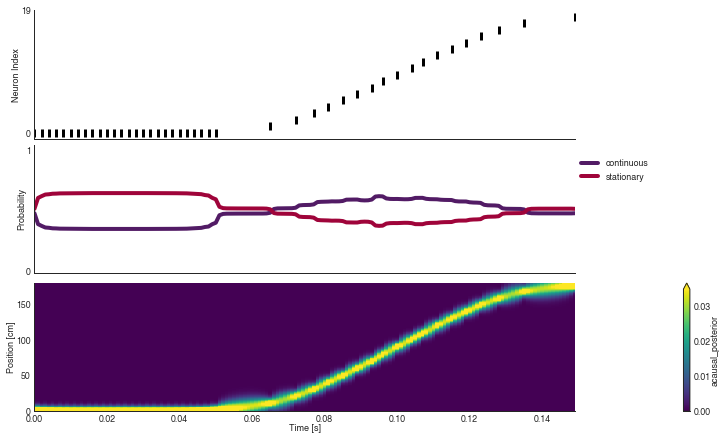

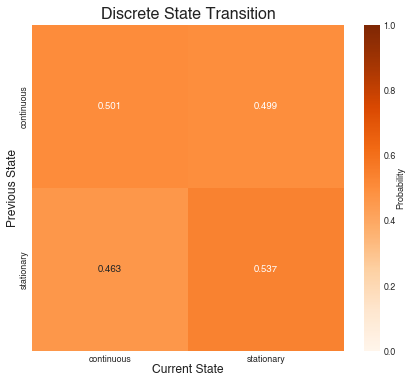

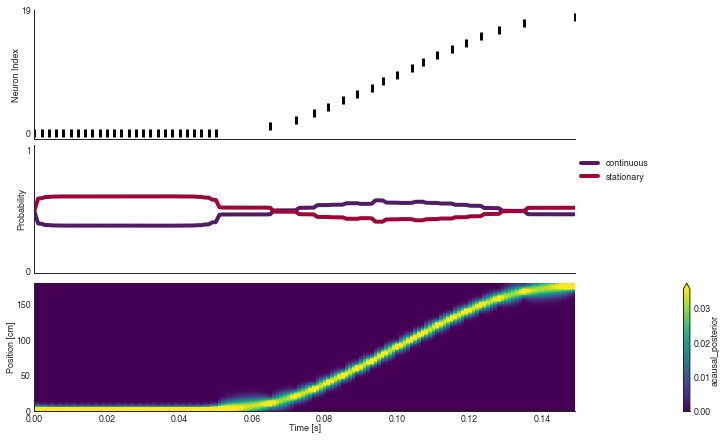

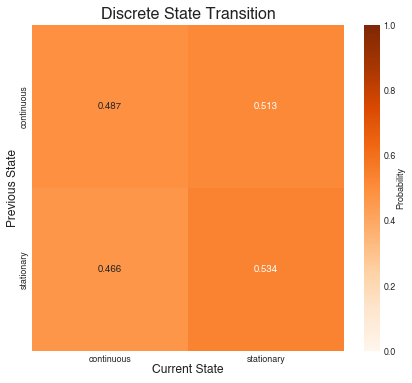

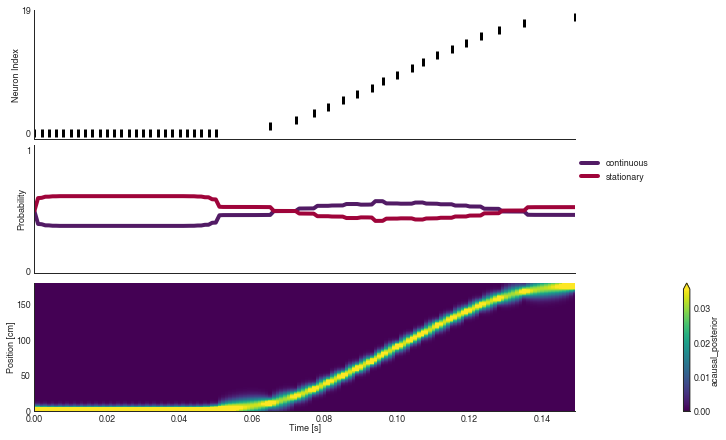

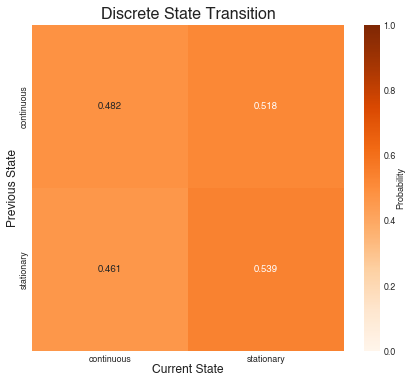

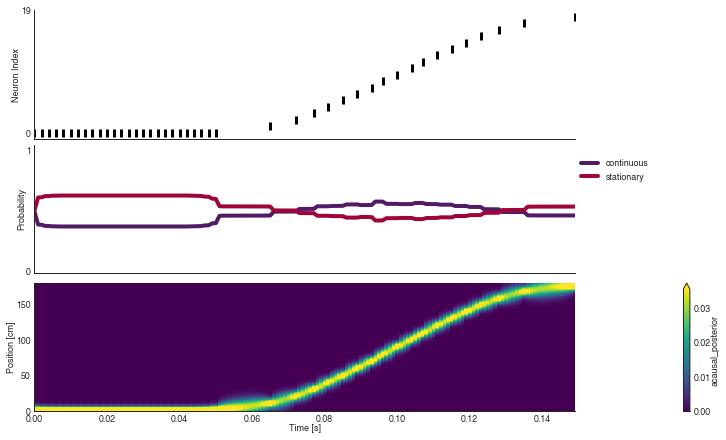

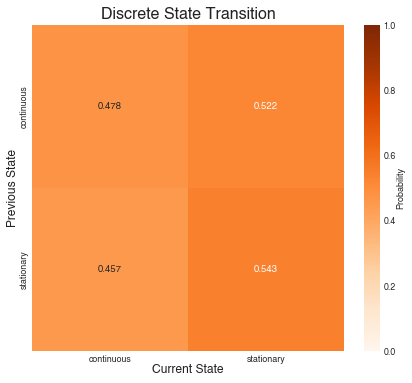

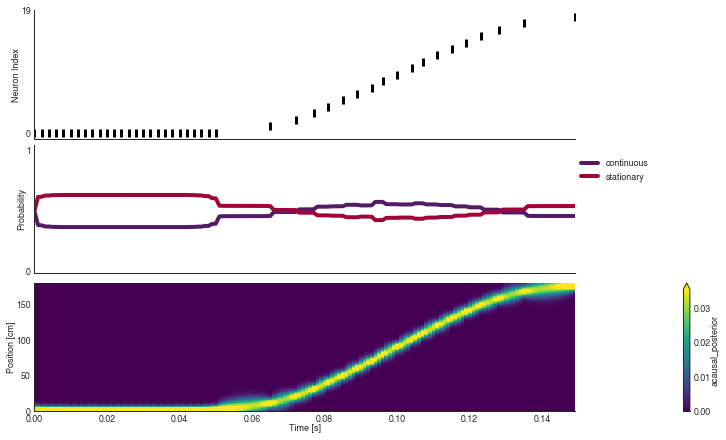

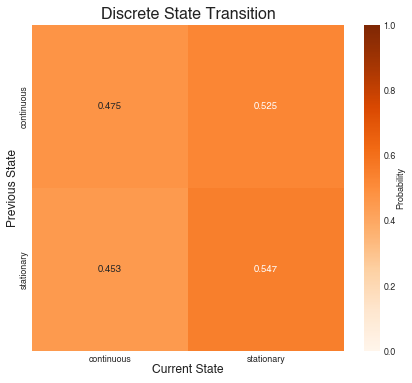

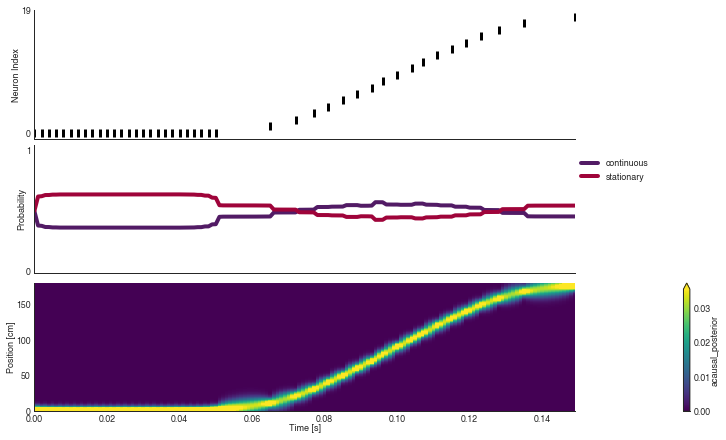

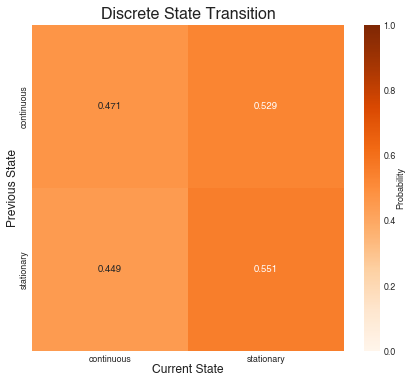

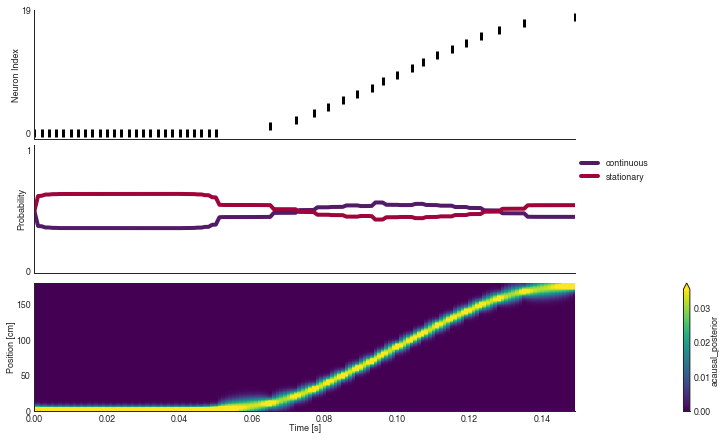

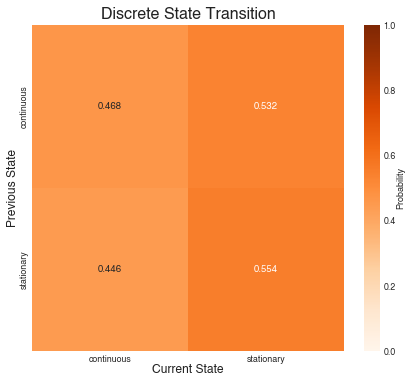

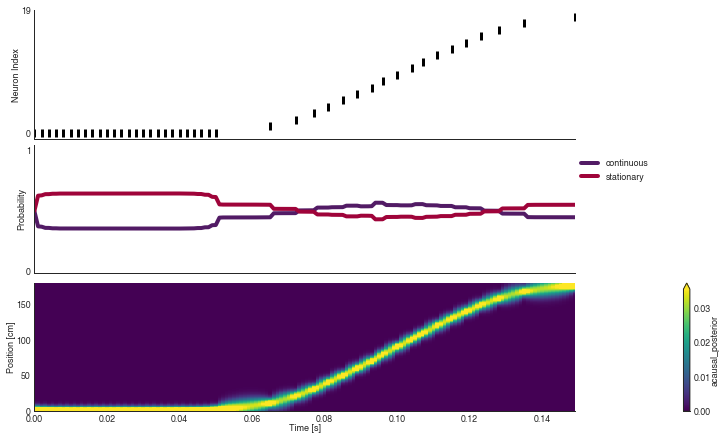

In [242]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Identity()],
                                [RandomWalk(movement_var=movement_var * 120), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)
_, test_spikes2 = make_continuous_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    A = estimate_discrete_state_transition(results)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

In [221]:
acausal_prob = results.acausal_posterior.sum('position').values
(acausal_prob[:-1, :, np.newaxis] * acausal_prob[1:, np.newaxis, :]).sum(axis=0)


array([[60.38766982, 17.62086676],
       [17.87202914, 53.11943428]])

In [222]:
n_time = len(acausal_prob)
A = np.zeros((2, 2))
for t in range(1, n_time):
    A[0, 0] += acausal_prob[t-1][0] * acausal_prob[t][0]
    A[0, 1] += acausal_prob[t-1][0] * acausal_prob[t][1]
    A[1, 0] += acausal_prob[t-1][1] * acausal_prob[t][0]
    A[1, 1] += acausal_prob[t-1][1] * acausal_prob[t][1]
    
A

array([[60.38766982, 17.62086676],
       [17.87202914, 53.11943428]])

In [211]:
A / acausal_prob[:-1].sum(axis=0)

array([[0.91873597, 0.10993127],
       [0.08853727, 0.88022974]])

array([86.29340283, 62.70659717])

In [178]:
estimate_discrete_state_transition(results)

array([[0.91873597, 0.08126403],
       [0.11977026, 0.88022974]])

array([[0.92929293, 0.07070707],
       [0.11111111, 0.88888889]])

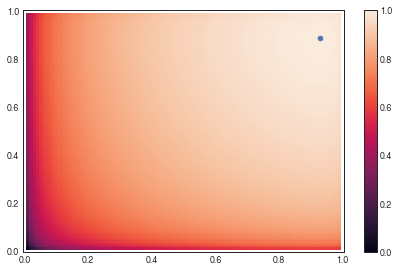

In [167]:
def get_Q(results, A):
    acausal_prob = results.acausal_posterior.sum('position').values
    return ((acausal_prob[:-1,:, np.newaxis] * acausal_prob[1:, np.newaxis, :]) * np.log(A)[np.newaxis]).sum()


p = np.linspace(0, 1, 100)
p_grid = np.stack([p.flat for p in np.meshgrid(p, p)], axis=1)
q = []
for p1, p2 in p_grid:
    A = np.asarray([[p1, 1 - p1],
                    [1 - p2, p2]])
    q.append(get_Q(results, A))

q = np.asarray(q).reshape((len(p), len(p)))
plt.pcolormesh(p, p, q)
plt.scatter(*p_grid[np.argmax(q)])
plt.colorbar()
p1, p2 = p_grid[np.argmax(q)]
A_opt = np.asarray([[p1, 1 - p1],
                    [1 - p2, p2]])
A_opt

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-53.238877294284556


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-57.949972351522405


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-63.32083815556169


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-66.32356067838599


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-67.04562267662669


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


-67.09686097909095


INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-67.07141324789202


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


-67.05239787369011


INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-67.04969656774234


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-67.06287355452434


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-67.08924658116638


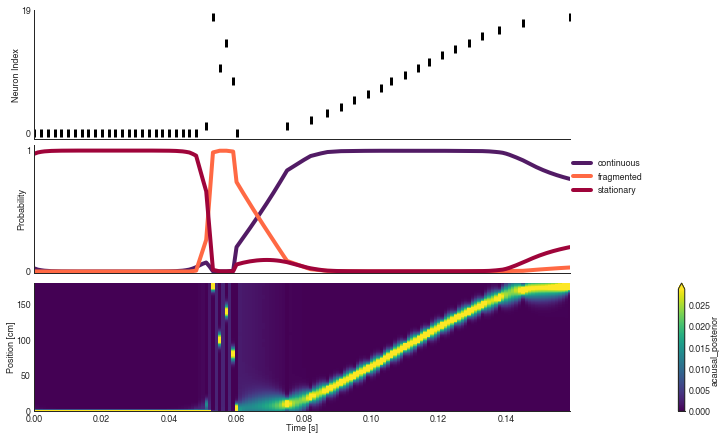

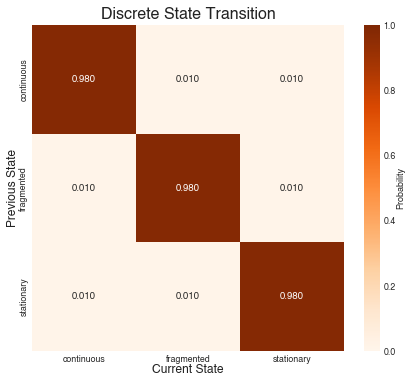

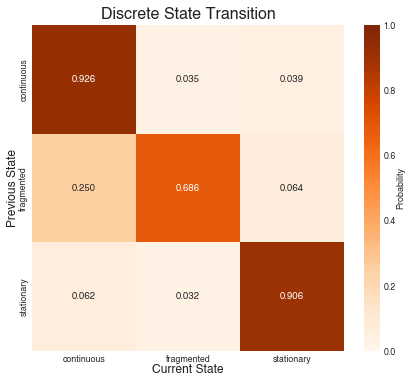

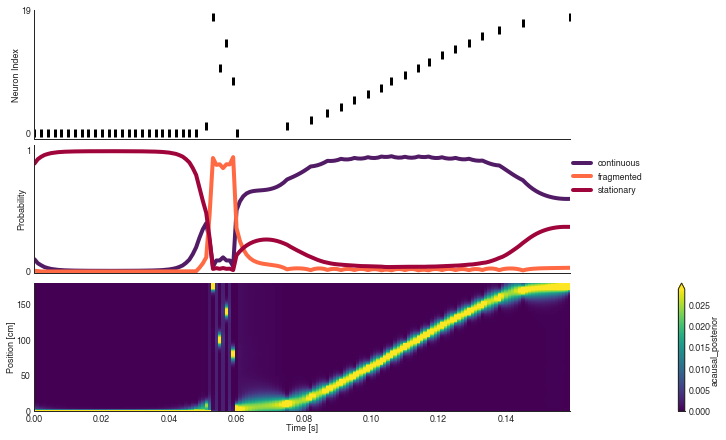

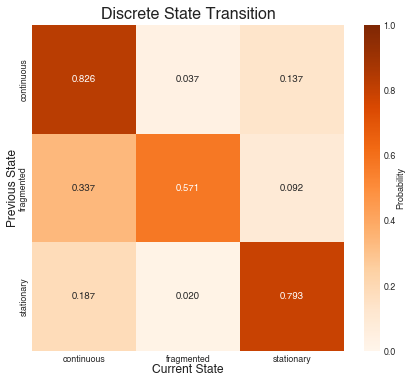

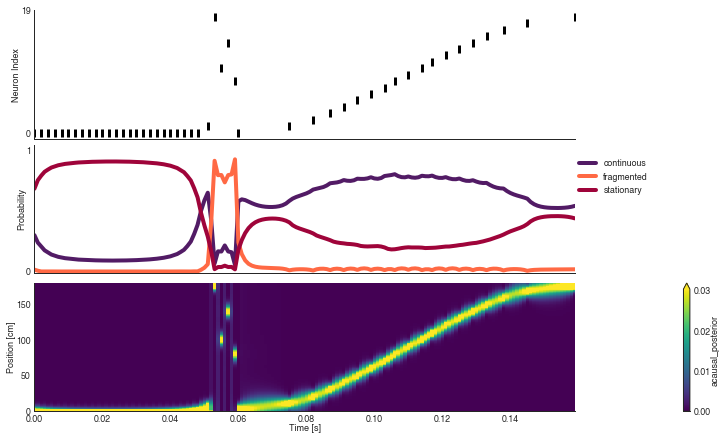

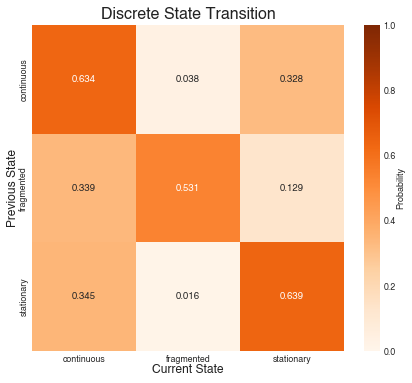

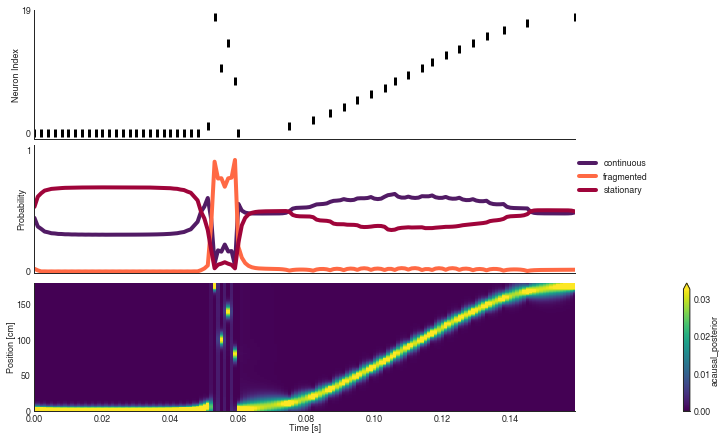

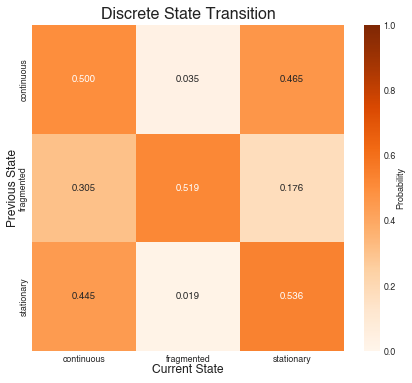

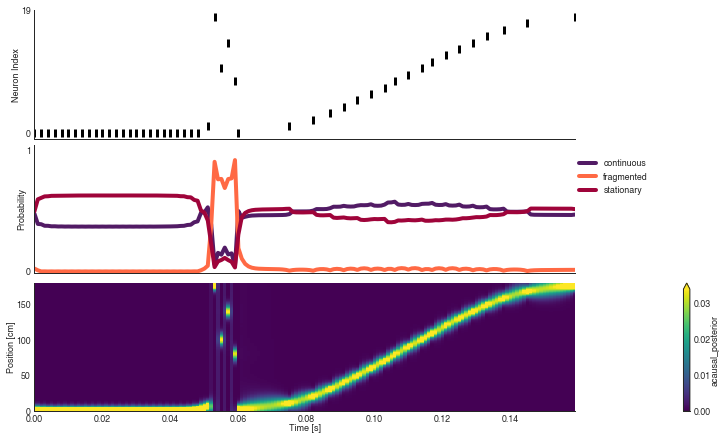

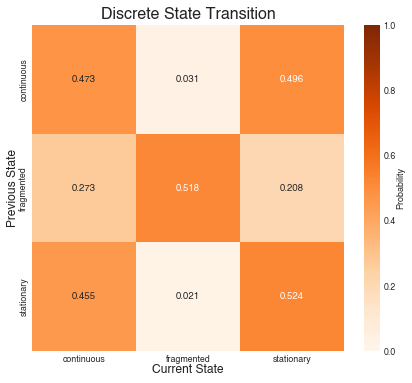

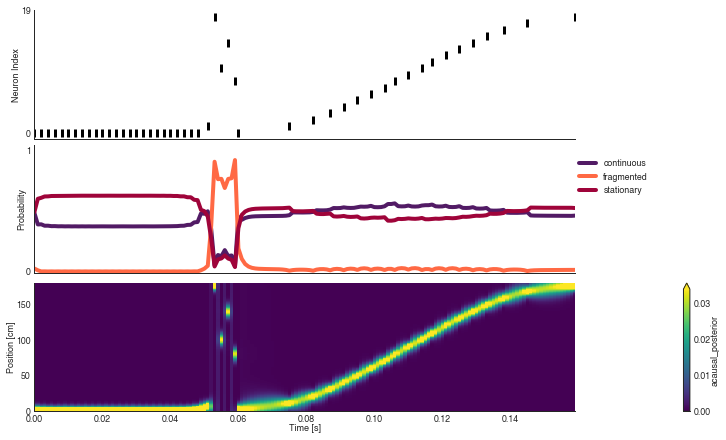

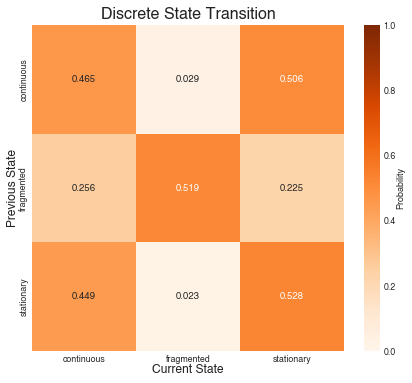

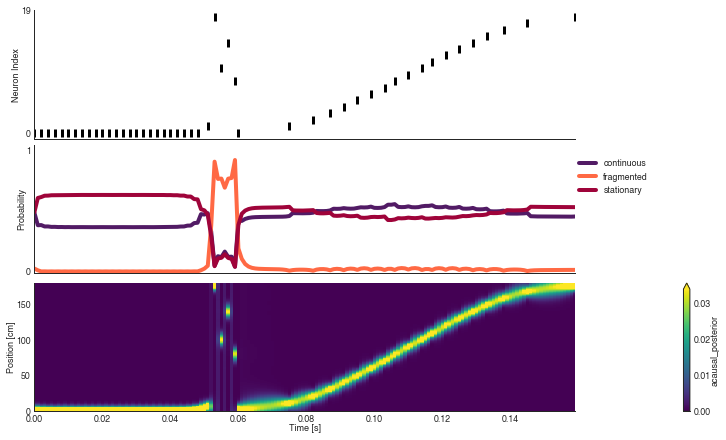

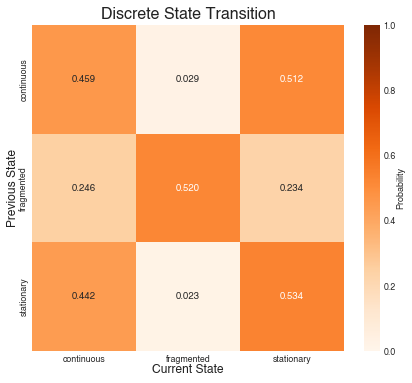

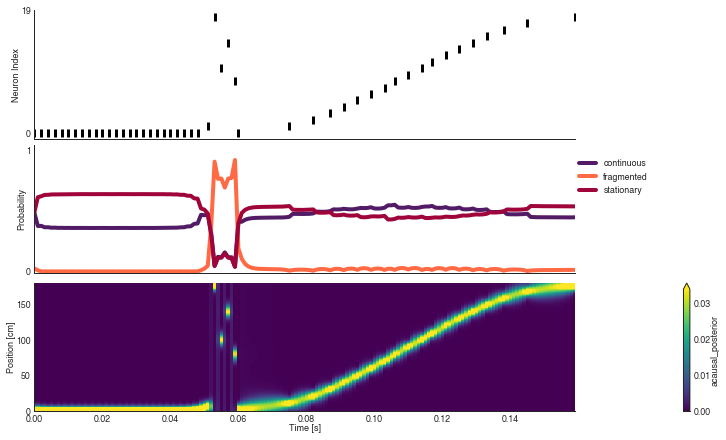

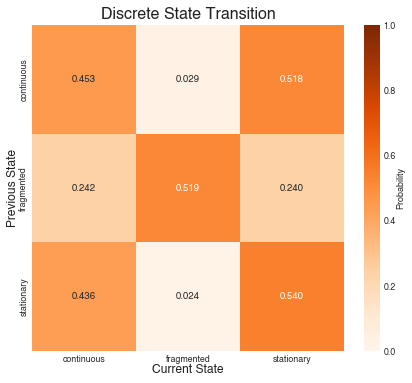

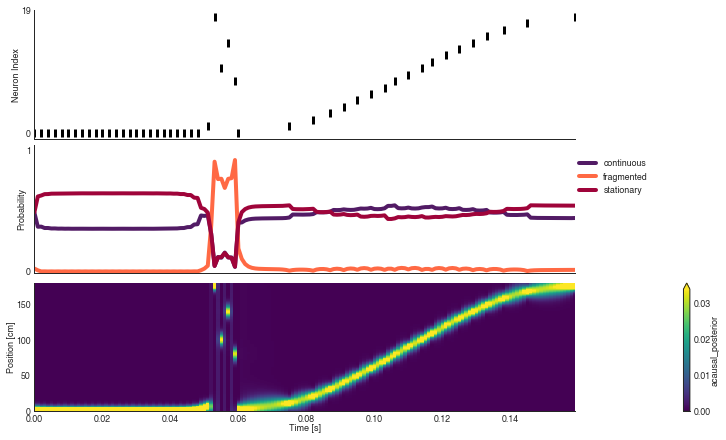

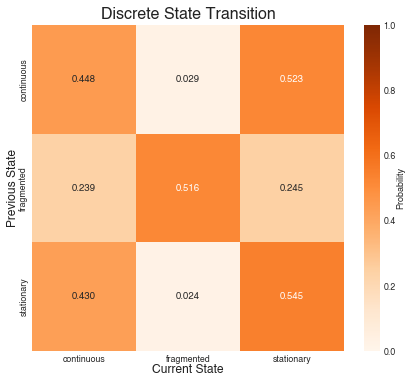

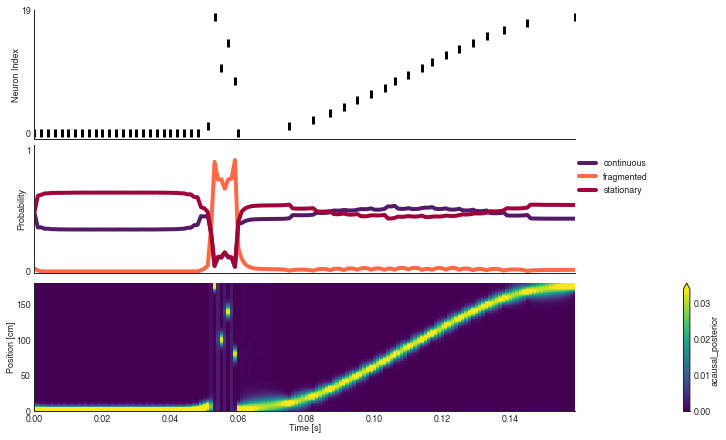

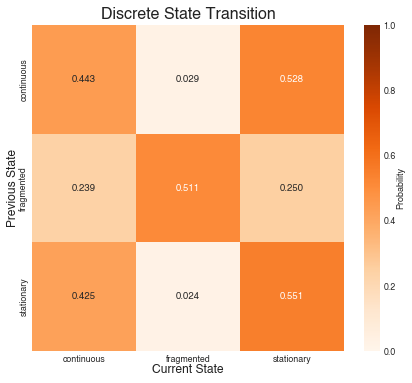

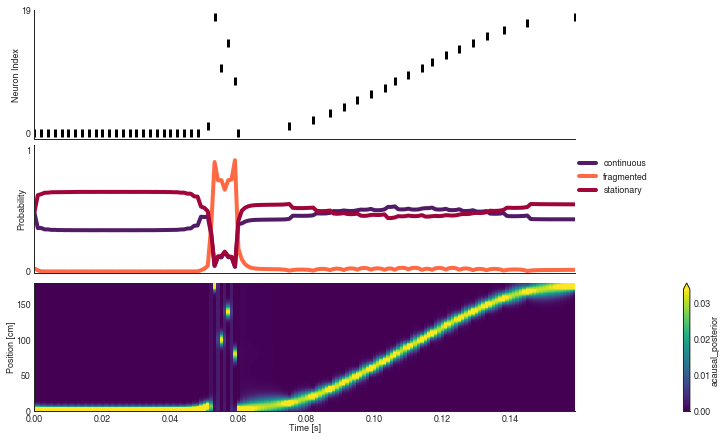

In [244]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)
_, test_spikes2 = make_fragmented_replay()
_, test_spikes3 = make_continuous_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes3))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

# replay_time, test_spikes = make_hover_continuous_hover_replay()
state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    A = estimate_discrete_state_transition(results)
    
    plt.figure(figsize=(7, 6))
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


-37.790552447011265


INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-40.95588124026553


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-47.02988493968363


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-51.34583792558172


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-52.75653265839689


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-52.971187166274426


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-52.959336475392426


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-52.92378663548249


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-52.892962187672175


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-52.869042092843266


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-52.85082430054457


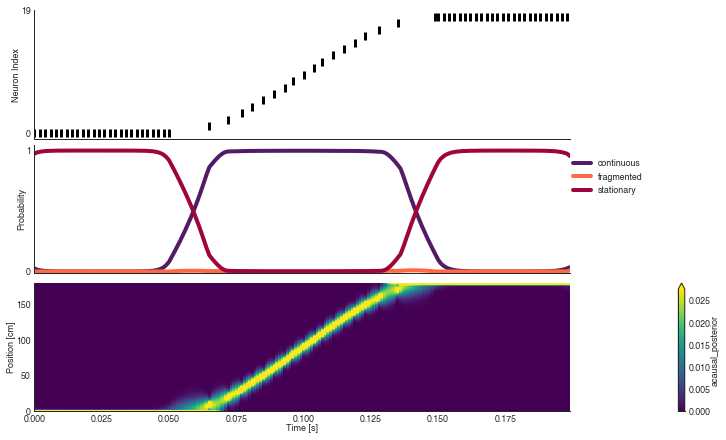

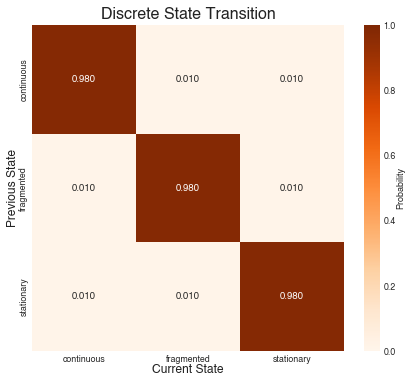

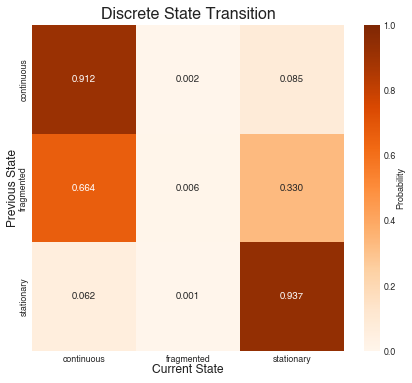

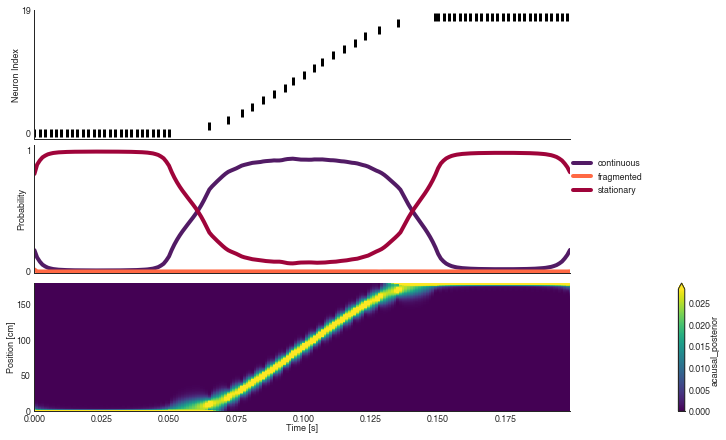

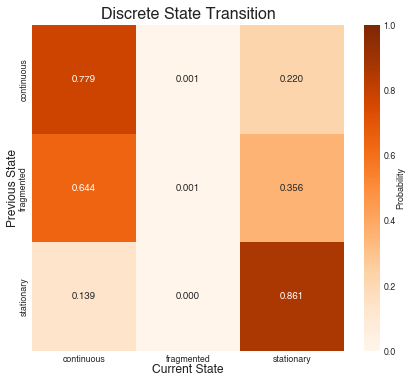

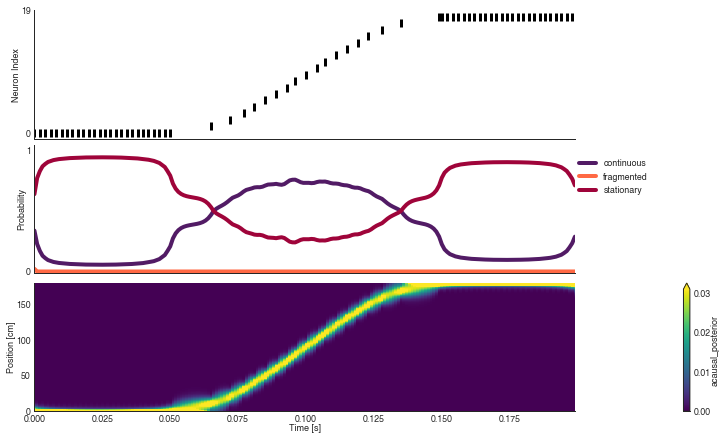

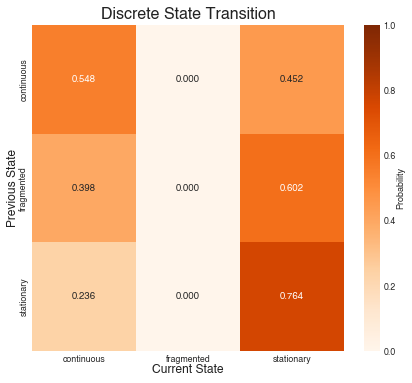

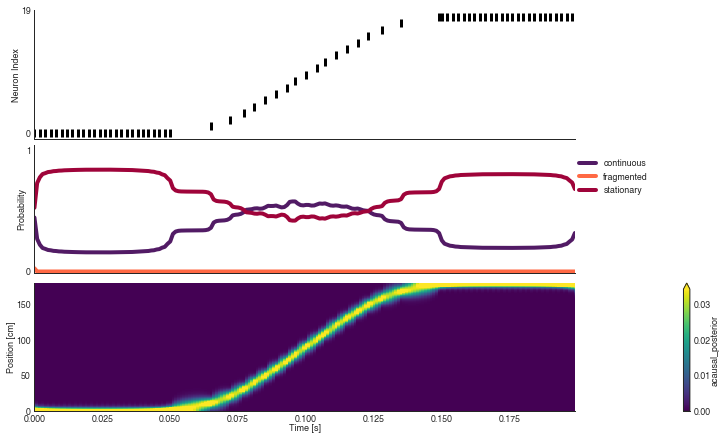

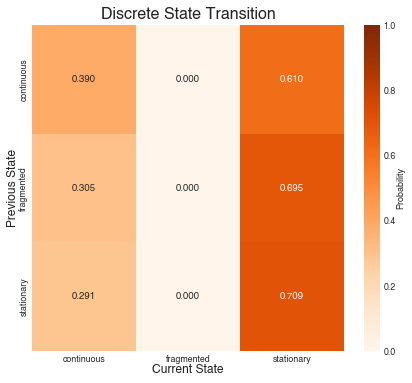

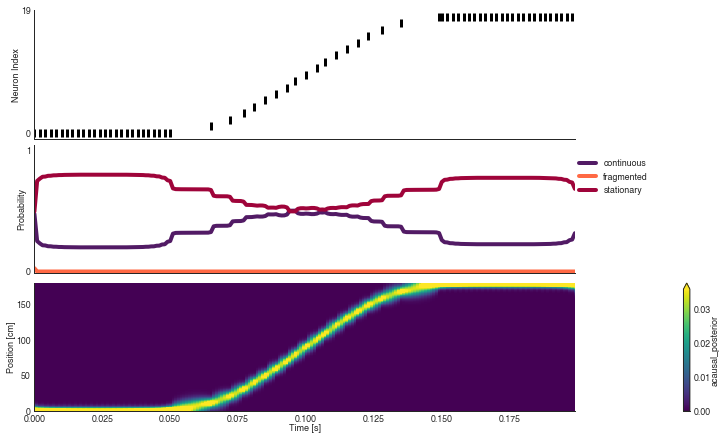

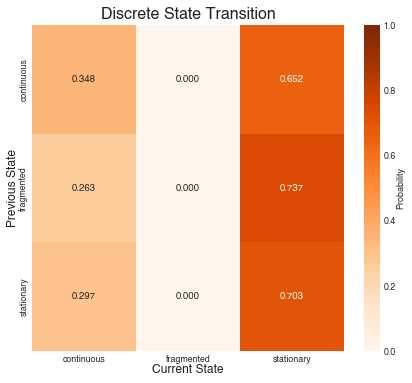

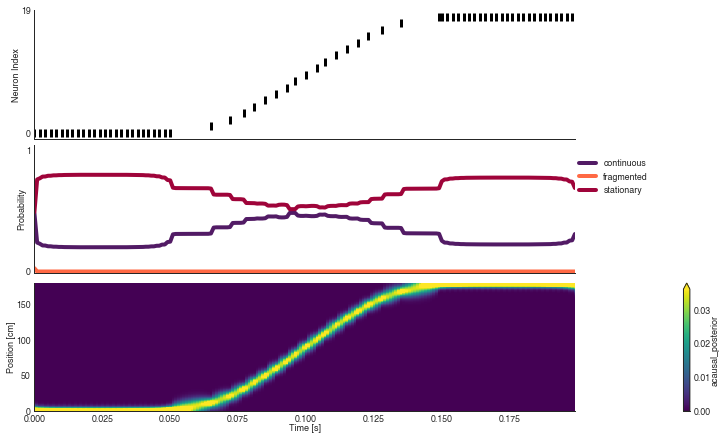

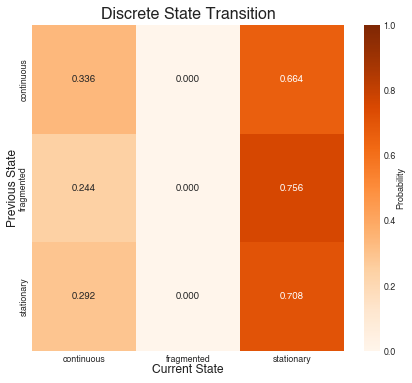

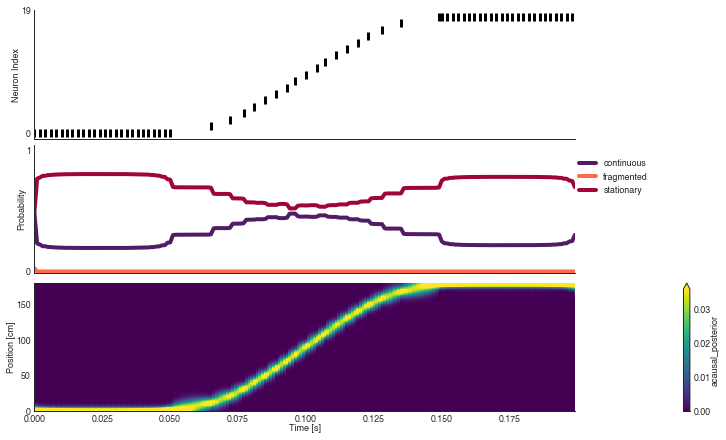

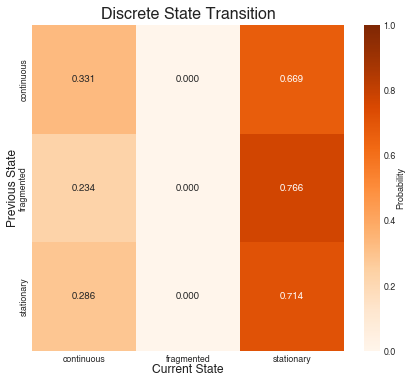

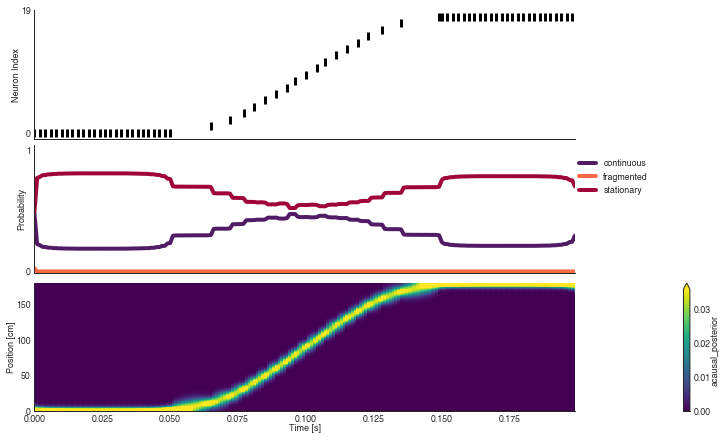

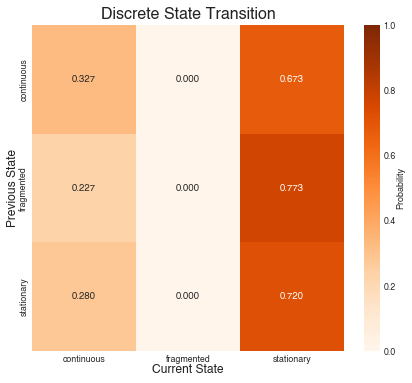

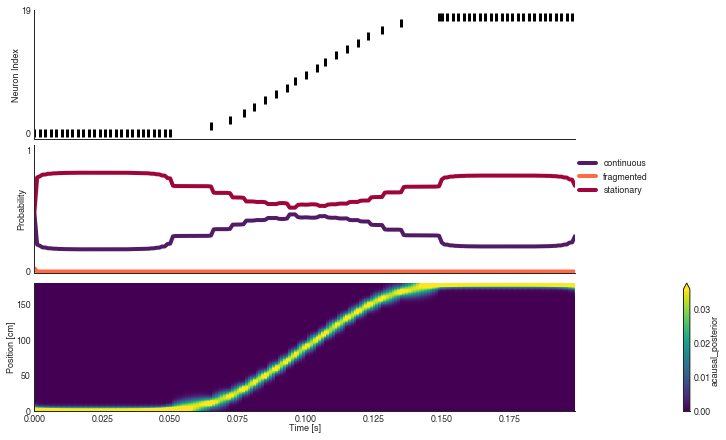

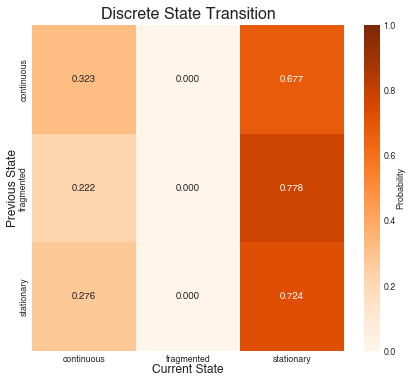

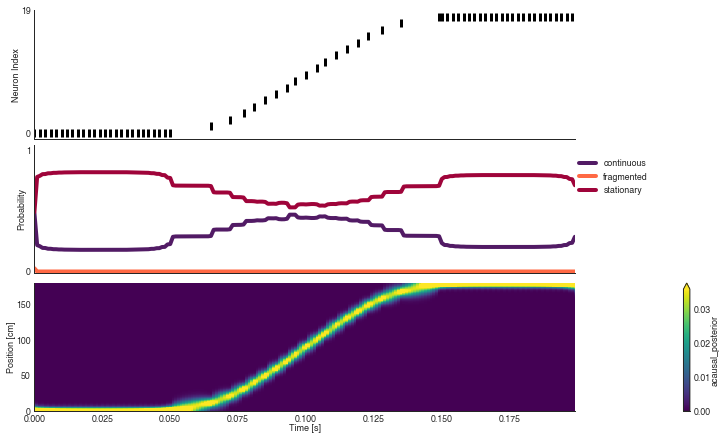

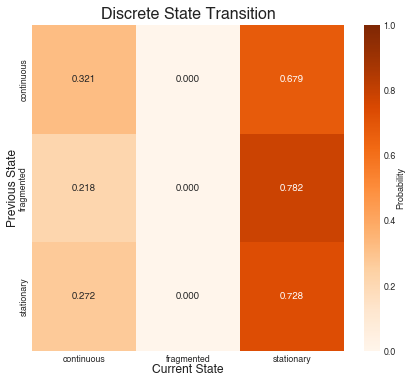

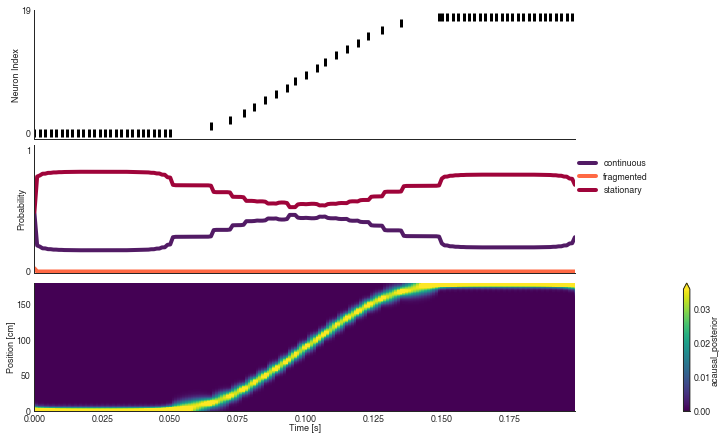

In [245]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

replay_time, test_spikes = make_hover_continuous_hover_replay()
state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    A = estimate_discrete_state_transition(results)
    
    plt.figure(figsize=(7, 6))
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)